In [3]:
"""
Project: AD4IDS - Anomaly Detection for Intrusion Detection Systems
Subproject: Challenge 2
Stage: 2- Evaluation
Authors: MONNIER Killian & BAKKARI Ikrame
Date: 01/2024
"""
import ipaddress
import pandas as pd
import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

port_bins = [0, 1023, 49151, 65535]
port_labels = ["WellKnownPorts", "RegisteredPorts", "DynamicPrivatePorts"]

packets_bins = [
    0,
    100,
    500,
    float("inf"),
]
packets_labels = ["Low", "Medium", "High"]

bytes_bins = [
    0,
    10000,
    50000,
    float("inf"),
]
bytes_labels = ["Small", "Medium", "Large"]


def parse_csv_to_dataframe(file_name):
    print("Parsing", file_name, "CSV file...")
    df = pd.read_csv(file_name)
    print("Done parsing CSV file in dataframe.")
    return df


def map_ip_to_interval(ip):
    try:
        ip = ipaddress.IPv4Address(ip)
    except ValueError:
        return "UnknownNetwork"
    if ip <= ipaddress.IPv4Address("128.0.0.0"):
        return "PrivateNetwork"
    elif ip <= ipaddress.IPv4Address("192.0.0.0"):
        return "PublicNetwork"
    elif ip <= ipaddress.IPv4Address("224.0.0.0"):
        return "MulticastNetwork"
    else:
        return "UnknownNetwork"

def parse_flags_to_list(flags_list):
    # split the flags string into a list of flags
    flags_list = [flag.strip() for flag in flags_list]
    flags_dict = {}
    for flag in flags_list:
        if flag != ".":
            flags_dict[f"flags_{flag}"] = 1
    return flags_dict


def convert_to_number(value):
    try:
        return int(value)
    except ValueError:
        # Si contient un M, multiplier par 1 000 000
        if value[-1] == "M":
            return int(float(value[:-1]) * 1000000)
        # Si contient un K, multiplier par 1 000
        elif value[-1] == "K":
            return int(float(value[:-1]) * 1000)
        else:
            # print(f"Unknown value: {value}")
            return 0


def preprocess_df(df):
    # Encodage One-Hot pour les adresses IP, en utilisant la fonction map_ip_to_interval
    df["Src_IP_Add"] = df["Src_IP_Add"].apply(map_ip_to_interval)
    df["Dst_IP_Add"] = df["Dst_IP_Add"].apply(map_ip_to_interval)
    df["Src_Pt"] = pd.cut(df["Src_Pt"], bins=port_bins, labels=port_labels, include_lowest=True)[0]
    df["Dst_Pt"] = pd.cut(df["Dst_Pt"], bins=port_bins, labels=port_labels, include_lowest=True)[0]
    df["Packets"] = pd.cut(df["Packets"], bins=packets_bins, labels=packets_labels, include_lowest=True)[0]
    df["Bytes"] = pd.to_numeric(df["Bytes"], errors='coerce')
    df["Bytes"] = pd.cut(df["Bytes"], bins=bytes_bins, labels=bytes_labels, include_lowest=True)[0]
    
    df = pd.get_dummies(df, columns=["Src_IP_Add", "Dst_IP_Add", "Src_Pt", "Dst_Pt", "Packets", "Bytes", "Protocol", "Tag"])

    # Pour les flags, vous pouvez les splitter et créer des colonnes séparées
    for flag in ["A", "F", "S", "R", "P"]:
        df[f"flags_{flag}"] = df["Flags"].str.contains(flag).astype(int)

    # Encodage One-Hot pour le tag
    df.drop(columns=["Timestamp", "Flags", "Flows"], inplace=True)
    
    return df

In [43]:
# csv_file = "data/traffic_os_TRAIN.csv"
csv_file = "data/traffic_os_TEST.csv"
# df_file = "data/df_traffic_train.pkl"
df_file = "data/df_traffic_test.pkl"

df = parse_csv_to_dataframe(csv_file)
df.head()

Parsing data/traffic_os_TEST.csv CSV file...


C:\Users\kiki\AppData\Local\Temp\ipykernel_14744\1271561174.py:36: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Done parsing CSV file in dataframe.


,Timestamp,Duration,Protocol,Src_IP_Add,Src_Pt,Dst_IP_Add,Dst_Pt,Packets,Bytes,Flows,Flags,Tos,Tag
0,2.724705e+09,0.000,TCP,192.168.100.5,445,192.168.220.14,42718.0,1,108,1,.AP...,0,UNK
1,2.724705e+09,0.002,TCP,192.168.220.14,42718,192.168.100.5,445.0,2,174,1,.AP...,0,UNK
2,2.724705e+09,0.002,TCP,192.168.220.10,59594,192.168.100.5,445.0,2,174,1,.AP...,0,UNK
3,2.724705e+09,0.000,TCP,192.168.100.5,445,192.168.220.10,59594.0,1,108,1,.AP...,0,UNK
4,2.724705e+09,0.000,TCP,10022_204,80,192.168.210.5,61252.0,1,66,1,.A....,32,UNK


In [44]:
# Nombre de lignes et de colonnes
print(df.shape)

# df_subset = df.head(100).copy()  # Sélectionner les 100 000 premières lignes

# Appliquer la fonction de preprocessing
df_preprocessed = preprocess_df(df)

(10310733, 13)


In [46]:
df_preprocessed.head()

,Duration,Tos,Src_IP_Add_MulticastNetwork,Src_IP_Add_PrivateNetwork,Src_IP_Add_UnknownNetwork,Dst_IP_Add_MulticastNetwork,Dst_IP_Add_UnknownNetwork,Src_Pt_WellKnownPorts,Dst_Pt_RegisteredPorts,Packets_Low,Bytes_Small,Protocol_ICMP,Protocol_IGMP,Protocol_TCP,Protocol_UDP,Tag_UNK,flags_A,flags_F,flags_S,flags_R,flags_P
0,0.000,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1
1,0.002,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1
2,0.002,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1
3,0.000,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1
4,0.000,32,0,0,1,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0


In [45]:
df_preprocessed.to_pickle(df_file)

Classification

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_pickle("data/df_traffic_train.pkl")
df_train["Dst_Pt_RegisteredPorts"] = 0
# print(df_train.head())
# breakpoint()

# Supposons que votre DataFrame s'appelle df
X = df_train.drop(['Tag_normal', 'Tag_attacker', 'Tag_victim'], axis=1)
y = df_train[['Tag_normal', 'Tag_attacker', 'Tag_victim']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

rf.fit(X, y)
# y_pred = rf.predict(X_test)


RandomForestClassifier(max_depth=20, random_state=42)

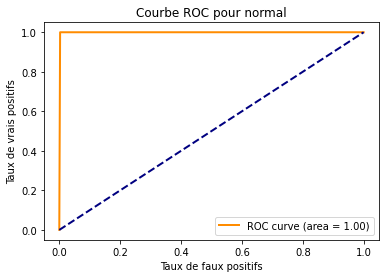

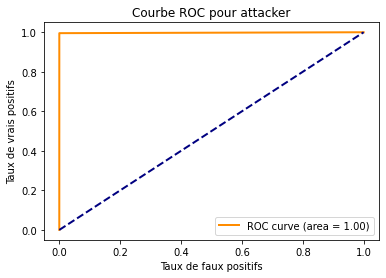

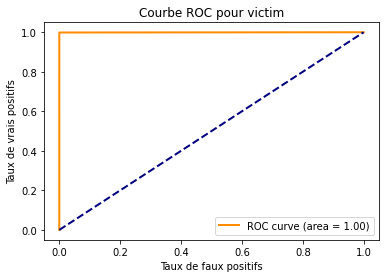

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binariser les étiquettes pour la courbe ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
predictions_binarized = label_binarize(y_pred, classes=[0, 1, 2])
labels = ["normal", "attacker", "victim"]

# Calculer la courbe ROC et l'AUC pour chaque classe
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], predictions_binarized[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC pour {label}')
    plt.legend(loc='lower right')
    plt.show()


In [51]:
# store model in a file
import pickle
with open('data/model_rf.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [4]:
import pickle
import pandas as pd

# predict with model
with open('data/model_rf.pkl', 'rb') as file:
    model = pickle.load(file)

df_test = pd.read_pickle("data/df_traffic_test.pkl")
# print(df_test.head())
# breakpoint()
df_test["Dst_Pt_DynamicPrivatePorts"] = 0
df_test.drop(columns=['Tag_UNK'])

# Assurer le même ordre de colonnes dans df2 que dans df1
df_train = pd.read_pickle("data/df_traffic_train.pkl")
df_train = df_train.drop(columns=['Tag_normal', 'Tag_attacker', 'Tag_victim'])
df_train["Dst_Pt_RegisteredPorts"] = 0

df_test = df_test[df_train.columns]

# print(df_test.head())
# breakpoint()

y_pred = model.predict(df_test)  # Prédictions
probs = model.predict_proba(df_test)  # Probabilités des prédictions

In [5]:
import json
import numpy as np

print(y_pred[:10])
print(probs[:10])
breakpoint()

# Labels textuels pour les prédictions
labels = ["normal", "attacker", "victim"]

# Convertir y_pred en labels textuels
pred_labels = [labels[np.argmax(row)] for row in y_pred]

# Calculer les probabilités pour chaque classe
probs_formatted = []
for prob_set in probs:
    prob_normal = [1 - prob[1] - prob[0] for prob in prob_set]  # Calculer la probabilité pour "normal"
    prob_attacker = [prob[0] for prob in prob_set]               # Probabilité pour "attacker"
    prob_victim = [prob[1] for prob in prob_set]                 # Probabilité pour "victim"
    combined_probs = list(zip(prob_attacker, prob_normal, prob_victim))
    probs_formatted.extend(combined_probs)


# Dictionnaire pour stocker les résultats
res = {
    "preds": pred_labels,  # Liste des étiquettes prédites
    "probs": probs_formatted,        # Liste des triplets de probabilités
    "names": ["Ikrame BAKKARI", "Killian MONNIER"],  # Noms des membres de l'équipe
    "method": "Random Forest",  # Nom de la méthode utilisée
    "version": 2       # Version de la soumission, ajustez selon le besoin
}

for key, value in res.items():
    if isinstance(value, np.ndarray):
        res[key] = value.tolist()

# Nom du fichier de sortie basé sur les noms et la version
file_name = f"IADI_IKI_chall2.results"

# Écriture des résultats dans le fichier
with open(file_name, "w") as f:
    json.dump(res, f)

print(f"Résultats sauvegardés dans {file_name}")

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[array([[5.84514751e-06, 9.99994155e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       ...,
       [5.84514751e-06, 9.99994155e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]]), array([[9.99994155e-01, 5.84514751e-06],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       ...,
       [9.99994155e-01, 5.84514751e-06],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]]), array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])]


In [14]:
import json

# Remplacez 'your_file.results' par le chemin vers votre fichier .results
file_path = 'IADI_IKI_chall2.results'

# Charger le fichier .results
with open(file_path, 'r') as file:
    data = json.load(file)

# Récupérer les prédictions
preds = data['preds']

# Compter le nombre d'attaques prédites
attack_count = preds.count('attacker')

# Compter le nombre de victimes prédites
victim_count = preds.count('victim')

# Afficher les résultats
print(f"Nombre de flux : {len(preds)}")
print(f"Nombre d'attaques ('attacker') prédites : {attack_count}")
print(f"Nombre de victimes ('victim') prédites : {victim_count}")


Nombre de flux : 10310733
Nombre d'attaques ('attacker') prédites : 906998
Nombre de victimes ('victim') prédites : 884774
